<a href="https://colab.research.google.com/github/FyodorPi/Wire_Coating/blob/main/Wire_Coating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import statistics as stat
import math
import re
from openpyxl import load_workbook, Workbook
from openpyxl.styles import Color, PatternFill, Font, Border, Alignment
from openpyxl.styles.differential import DifferentialStyle
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule
from openpyxl.chart import BarChart, LineChart, ScatterChart, Reference, Series
from openpyxl.worksheet.table import Table, TableStyleInfo
from pandas.io.excel import ExcelWriter
from google.colab import drive

# Монтируем Google Drive
drive.mount('/content/drive')

# Настройки продукта
product = ('ON_prov', 'Проволока ОН')
elem = 'Mn'
charact = 'Плотн_цинк'

# Пути
base_path = f"/content/drive/My Drive/1Статистика/Статистика/oracle_{product[0]}"
result_path = f"/content/drive/My Drive/1Статистика/Статистика/result_{product[0]}"
os.chdir(base_path)

# Словарь для линий
my_dict = {'ППК': ['FIB 1', 'FIB 2'], 'СПП': ['FIB', 'ICE']}

def extract_value(x):
    """Безопасно извлекает значение из массива NumPy или возвращает скаляр."""
    if isinstance(x, np.ndarray):
        if x.ndim == 0:
            return x.item()
        elif x.size > 0:
            return x[0]
        else:
            return np.nan
    else:
        return x

def load_and_combine_data():
    """Загружает и объединяет данные из Excel-файлов."""
    xl_files = glob.glob('*')
    combined = pd.DataFrame()
    combined2 = pd.DataFrame()
    combined3 = pd.DataFrame()

    for xl_file in xl_files:
        try:
            xl_file_obj = pd.ExcelFile(xl_file)
            for sheet_name in xl_file_obj.sheet_names:
                if sheet_name.startswith('Результаты'):
                    data = pd.read_excel(xl_file_obj, header=[0], sheet_name=sheet_name)
                    data = data.drop(labels=[0], axis=0).rename(columns={'Unnamed: 10': 'Минимум_норм', 'Unnamed: 11': 'Максимум_норм'})
                    data = data.astype({'Минимум': np.float64, 'Максимум': np.float64}).dropna(subset=['Минимум', 'Максимум'])
                    data['mean'] = data[['Минимум', 'Максимум']].mean(axis=1)
                    combined = pd.concat([combined, data], sort=False)

                elif sheet_name.startswith('Пробы'):
                    data2 = pd.read_excel(xl_file_obj, header=[0], sheet_name=sheet_name)
                    data2["Диаметр"] = data2["Описание позиции"].str.extract(r'(\d{1,3},\d)', expand=False).str.replace(',', '.')
                    data2 = data2.astype({'Диаметр': np.float64})
                    data2['Размер-марка-НД'] = data2['Описание позиции'].str.replace('Проволока ', '')
                    combined2 = pd.concat([combined2, data2], sort=False)

                elif sheet_name.startswith('Вх.контроль'):
                    data3 = pd.read_excel(xl_file_obj, header=[0], sheet_name=sheet_name).drop(labels=[0], axis=0)
                    combined3 = pd.concat([combined3, data3], sort=False)
        except Exception as e:
            print(f"Ошибка при обработке файла {xl_file}: {e}")
    combined = combined[combined['Описание позиции'].str.contains('3282', na=False)]
    combined2 = combined2[combined2['Описание позиции'].str.contains('3282', na=False)]
    # print(combined2)
    return combined, combined2, combined3

def process_combined_data(combined, combined2, combined3):
    """Обрабатывает объединённые данные: фильтрует, добавляет столбцы."""
    # Фильтр по элементу
    combined4 = combined3.loc[combined3["Показатель"] == elem].astype({'Данные СК поставщика': np.float64})
    combined4 = combined4.groupby(['Плавка'])['Данные СК поставщика'].agg(["mean"]).rename(columns={'mean': elem})

    # Объединение
    combine = pd.merge(combined, combined2, on='Проба', how='left')
    combine = pd.merge(combine, combined4, on='Плавка', how='left')

    # Очистка и преобразования
    combine['Код проверки'] = combine['Код проверки'].str.replace(r'[|/]', '-', regex=True).str.replace('-М', '')
    combine['Класс проверки (код)'] = combine['Класс проверки (код)'].str.replace(r'[|М-]', '-', regex=True)
    combine = combine.dropna(subset=['Минимум'])

    # Добавление столбцов
    combine['Производство'] = combine['Партия_x'].apply(lambda x: 'ППК' if str(x).startswith('А84') else 'СПП')
    combine['Линия'] = combine.apply(lambda row:
        'FIB 1' if row['Производство'] == 'ППК' and re.search(r'\.\d{2}\.', row['Партия_x']) else
        'FIB 2' if row['Производство'] == 'ППК' else
        'FIB' if row['Производство'] == 'СПП' and row['Партия_x'].endswith('.1') else
        'ICE', axis=1)

    # Присвоение норм
    def assign_values(row):
        diam = row['Диаметр']
        prod = row['Производство']
        if prod == 'ППК':
            conditions = [(diam >= 1.0) & (diam <= 1.2), (diam >= 1.3) & (diam <= 2.0), (diam >= 2.2) & (diam <= 2.5),
                          (diam >= 2.8) & (diam <= 3.6), (diam >= 3.7) & (diam <= 5.5), (diam >= 5.6) & (diam <= 6.0)]
            choices_range = ['1.0-1.2', '1.3-2.0', '2.2-2.5', '2.8-3.6', '3.7-5.5', '5.6-6.0']
            values_max = [70, 80, 90, 100, 110, 110]
        elif prod == 'СПП':
            conditions = [(diam >= 1.5) & (diam <= 2.0), (diam >= 2.2) & (diam <= 2.7), (diam >= 2.8) & (diam <= 3.6), (diam >= 3.7) & (diam <= 5.0)]
            choices_range = ['1.5-2.0', '2.2-2.7', '2.8-3.6', '3.7-5.0']
            values_max = [80, 90, 100, 110]
        else:
            return np.nan, 'Не определено'
        range_val = np.select(conditions, choices_range, default='Не определено')
        max_val = np.select(conditions, values_max, default=np.nan)
        return max_val, range_val

    combine[['Максимум_норм', 'Диапазон диаметров']] = combine.apply(assign_values, axis=1, result_type='expand')
    combine['Максимум_норм'] = combine['Максимум_норм'].apply(extract_value)

    # Фильтр по характеристике
    combine = combine.loc[combine["Код проверки"] == charact]

    # print(combine)

    return combine







Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def analyze_compliance(combine_df):
    """
    Функция для анализа соответствия фактических значений плотности покрытий нормативным значениям.
    Принимает DataFrame combine_df с колонками: 'Линия', 'Диапазон диаметров', 'Минимум_норм', 'Максимум_норм', 'Минимум', 'Максимум'.
    Возвращает сводную таблицу (pivot table) и выводит её в терминал.
    """
    # Преобразование числовых колонок в float, заменяя нечисловые значения на NaN
    numeric_cols = ['Минимум_норм', 'Максимум_норм', 'Минимум', 'Максимум']
    for col in numeric_cols:
        combine_df[col] = pd.to_numeric(combine_df[col], errors='coerce')

    # Преобразование колонок индекса в строки (для избежания ошибки с ndarray)
    combine_df['Линия'] = combine_df['Линия'].astype(str)
    combine_df['Диапазон диаметров'] = combine_df['Диапазон диаметров'].astype(str)

    # Функция для проверки соответствия партии
    def check_party_compliance(row):
        min_fact = row['Минимум']
        max_fact = row['Максимум']
        min_norm = row['Минимум_норм']
        max_norm = row['Максимум_норм']

        # Проверка на NaN
        if pd.isna(min_fact) or pd.isna(max_fact) or pd.isna(min_norm) or pd.isna(max_norm):
            return 'Недостаточно данных'

        if min_fact >= min_norm and max_fact <= max_norm:
            return 'Соответствует'
        elif max_fact > max_norm:
            return 'Превышение максимума'
        elif min_fact < min_norm:
            return 'Ниже минимума'
        else:
            return 'Частичное несоответствие'

    # Применение проверки к DataFrame
    combine_df['Статус'] = combine_df.apply(check_party_compliance, axis=1)

    # Разделение на два DataFrame по 'Производство'
    ppk_df = combine_df[combine_df['Производство'] == 'ППК']
    spp_df = combine_df[combine_df['Производство'] == 'СПП']

    # Словарь для хранения результатов
    results = {}

    # Функция для анализа одного DataFrame (вспомогательная)
    def analyze_subset(df, name):
        valid_df = df[df['Статус'] != 'Недостаточно данных']
        total_valid = len(valid_df)
        if total_valid == 0:
            print(f"{name}: Нет валидных данных для анализа.")
            return None

        compliant = len(valid_df[valid_df['Статус'] == 'Соответствует'])
        exceeding_max = len(valid_df[valid_df['Статус'] == 'Превышение максимума'])
        below_min = len(valid_df[valid_df['Статус'] == 'Ниже минимума'])
        percent_exceeding_max = (exceeding_max / total_valid) * 100

        print(f"\n{name} - Общее количество валидных партий: {total_valid}")
        print(f"Соответствуют: {compliant} ({compliant/total_valid*100:.2f}%)")
        print(f"Превышение максимума: {exceeding_max} ({percent_exceeding_max:.2f}%)")
        print(f"Ниже минимума: {below_min} ({below_min/total_valid*100:.2f}%)")
        print(f"Недостаточно данных: {len(df) - total_valid}")

        # Построение сводной таблицы (только для валидных данных)
        pivot = valid_df.pivot_table(
            index=['Линия', 'Диапазон диаметров'],
            values=['Статус', 'Минимум', 'Максимум'],
            aggfunc={
                'Статус': lambda x: (x == 'Соответствует').sum() / len(x) * 100,  # Процент соответствий
                'Минимум': 'mean',  # Средний фактический минимум
                'Максимум': 'mean'   # Средний фактический максимум
            }
        ).rename(columns={'Статус': 'Процент соответствий (%)'})

        # Вывод сводной таблицы в терминал с форматированием
        print(f"\n{name} - Сводная таблица (вывод в терминал):")
        print(pivot.to_string(float_format='%.2f', index=True, justify='left'))

        return pivot

    # Анализ для ППК
    results['ППК'] = analyze_subset(ppk_df, 'ППК')

    # Анализ для СПП
    results['СПП'] = analyze_subset(spp_df, 'СПП')

    return results  # Возвращаем словарь с двумя таблицами


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, pearsonr

def statistical_analysis_by_production(df,
                                       density_col_min='Минимум',
                                       density_col_max='Максимум',
                                       production_col='Производство',
                                       diameter_col='Диапазон диаметров'):
    """
    Статистический анализ плотности покрытий отдельно для ППК и СПП.

    Параметры:
    - df: DataFrame с данными.
    - density_col_min, density_col_max: колонки с минимальными и максимальными значениями плотности.
    - production_col: колонка с типом производства ('ППК' или 'СПП').
    - diameter_col: колонка с диапазонами диаметров.

    Анализ включает:
    - Расчет средней плотности (среднее между минимумом и максимумом).
    - Статистики по диаметрам в каждой группе производства.
    - ANOVA по диаметрам в каждой группе.
    - Корреляция между диаметром и плотностью в каждой группе.

    Результат: словарь с результатами для 'ППК' и 'СПП'.
    """
    results = {}

    # Вычисляем среднюю плотность
    df['Плотность'] = (pd.to_numeric(df[density_col_min], errors='coerce') +
                      pd.to_numeric(df[density_col_max], errors='coerce')) / 2

    # Парсим средний диаметр из диапазона
    def parse_diameter_range(range_str):
        try:
            parts = range_str.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        except:
            return np.nan

    df['Средний_диаметр'] = df[diameter_col].apply(parse_diameter_range)

    # Удаляем записи с NaN в ключевых колонках
    df_clean = df.dropna(subset=['Плотность', 'Средний_диаметр', production_col])

    print("=== Статистический анализ по типам производства ===\n")

    for prod_type in df_clean[production_col].unique():
        print(f"--- Анализ для производства: {prod_type} ---")
        df_prod = df_clean[df_clean[production_col] == prod_type]

        # Статистики по диаметрам
        stats_by_diameter = df_prod.groupby(diameter_col)['Плотность'].agg(['mean', 'median', 'std']).round(2)
        print("\nСтатистики по диапазонам диаметров:")
        print(stats_by_diameter)

        # ANOVA по диаметрам
        groups = [group['Плотность'].values for name, group in df_prod.groupby(diameter_col)]
        if len(groups) > 1:
            f_stat, p_value = f_oneway(*groups)
            print(f"\nANOVA: F-статистика = {f_stat:.2f}, p-значение = {p_value:.4f}")
            if p_value < 0.05:
                print("Вывод: Значимые различия между группами по диаметрам (p < 0.05).")
            else:
                print("Вывод: Нет значимых различий между группами (p >= 0.05).")
        else:
            print("\nANOVA: Недостаточно групп для анализа.")

        # Корреляция диаметр - плотность
        corr, p_corr = pearsonr(df_prod['Средний_диаметр'], df_prod['Плотность'])
        print(f"\nКорреляция Пирсона между диаметром и плотностью: r = {corr:.2f}, p = {p_corr:.4f}")
        if p_corr < 0.05:
            print("Вывод: Значимая корреляция (p < 0.05).")
        else:
            print("Вывод: Нет значимой корреляции (p >= 0.05).")

        print("\n")

        results[prod_type] = {
            'stats_by_diameter': stats_by_diameter,
            'anova': {'f_stat': f_stat, 'p_value': p_value} if len(groups) > 1 else None,
            'correlation': {'r': corr, 'p_value': p_corr}
        }

    return results


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_analysis_by_production(df, production_col='Производство', diameter_col='Диапазон диаметров'):
    # Подготовка данных
    df['Плотность'] = (pd.to_numeric(df['Минимум'], errors='coerce') +
                      pd.to_numeric(df['Максимум'], errors='coerce')) / 2

    def parse_diameter_range(range_str):
        try:
            parts = range_str.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        except:
            return np.nan

    df['Средний_диаметр'] = df[diameter_col].apply(parse_diameter_range)
    df_clean = df.dropna(subset=['Плотность', 'Средний_диаметр', production_col, 'Линия'])  # Добавлено 'Линия'

    for prod_type in df_clean[production_col].unique():
        print(f"\n=== Визуализации для производства: {prod_type} ===")
        df_prod = df_clean[df_clean[production_col] == prod_type]

        if df_prod.empty:
            print(f"Нет данных для {prod_type}.")
            continue

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Визуализации для {prod_type}', fontsize=16)

        sns.boxplot(data=df_prod, x=diameter_col, y='Плотность', ax=axes[0])
        axes[0].set_title('Boxplot плотности по диапазонам диаметров')
        axes[0].set_xlabel('Диапазон диаметров')
        axes[0].set_ylabel('Плотность')
        axes[0].tick_params(axis='x', rotation=45)

        sns.scatterplot(data=df_prod, x='Средний_диаметр', y='Плотность', ax=axes[1])
        axes[1].set_title('Корреляция: Средний диаметр vs Плотность')
        axes[1].set_xlabel('Средний диаметр')
        axes[1].set_ylabel('Плотность')
        sns.regplot(data=df_prod, x='Средний_диаметр', y='Плотность', ax=axes[1], scatter=False, color='red')

        # Группируем по диапазону диаметров и по линии
        mean_density = df_prod.groupby([diameter_col, 'Линия'])['Плотность'].mean().reset_index()

        # Добавляем hue='Линия', чтобы увидеть разбивку по линиям
        sns.barplot(data=mean_density, x=diameter_col, y='Плотность', hue='Линия', ax=axes[2])
        axes[2].set_title('Средняя плотность по диапазонам диаметров и линиям')
        axes[2].set_xlabel('Диапазон диаметров')
        axes[2].set_ylabel('Средняя плотность')
        axes[2].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()


In [ ]:
def calculate_capability_indices(df, production_col='Производство', diameter_col='Диапазон диаметров', density_col='Плотность'):
    """
    Функция для расчета индексов capability (Cp, Cpk, Pp, Ppk) для плотности покрытий
    по каждому диапазону диаметров и линии, отдельно для каждого типа производства (ППК и СПП).

    Предположения:
    - Плотность рассчитывается как (Минимум + Максимум) / 2, если не передана.
    - LSL = Минимум_норм, USL = Максимум_норм для каждого диапазона (как spec limits для плотности).
    - σ (стандартное отклонение) рассчитывается из данных плотности по диапазону и линии.
    - Если данных мало (например, 1 строка), σ = 0, и индексы могут быть inf или nan.
    - Индексы Cp, Cpk, Pp, Ppk округляются до двух знаков после запятой.

    Параметры:
    - df: DataFrame с данными (должен содержать столбец 'Линия').
    - production_col: Колонка с типом производства.
    - diameter_col: Колонка с диапазонами диаметров.
    - density_col: Колонка с плотностью (если уже рассчитана; иначе рассчитаем).

    Возвращает:
    - Словарь с DataFrame для каждого типа производства: {'ППК': df_ppk, 'СПП': df_spp}
    """
    # Рассчитаем плотность, если не передана
    if density_col not in df.columns:
        df = df.copy()
        df['Плотность'] = (pd.to_numeric(df['Минимум'], errors='coerce') +
                           pd.to_numeric(df['Максимум'], errors='coerce')) / 2

    # Группировка по производству и диапазону диаметров и линии
    results = {}
    for prod in df[production_col].unique():
        df_prod = df[df[production_col] == prod].copy()

        # Группировка по диапазону диаметров и линии
        grouped = df_prod.groupby([diameter_col, 'Линия']).agg(
            Средняя_плотность=('Плотность', 'mean'),
            Std_плотность=('Плотность', 'std'),
            LSL=('Минимум_норм', 'first'),  # LSL из столбца Минимум_норм
            USL=('Максимум_норм', 'first'),  # USL из столбца Максимум_норм
            Количество=('Плотность', 'count')
        ).reset_index()

        # Заполним Std_плотность 0, если nan (для случаев с 1 значением)
        grouped['Std_плотность'] = grouped['Std_плотность'].fillna(0)

        # Расчет индексов
        def calc_cp(row):
            if row['Std_плотность'] == 0 or pd.isna(row['USL']) or pd.isna(row['LSL']):
                return np.nan
            return (row['USL'] - row['LSL']) / (6 * row['Std_плотность'])

        def calc_cpk(row):
            if row['Std_плотность'] == 0 or pd.isna(row['USL']) or pd.isna(row['LSL']):
                return np.nan
            cpu = (row['USL'] - row['Средняя_плотность']) / (3 * row['Std_плотность'])
            cpl = (row['Средняя_плотность'] - row['LSL']) / (3 * row['Std_плотность'])
            return min(cpu, cpl)

        # Для Pp/Ppk используем ту же σ (поскольку нет subgroups, Pp = Cp, Ppk = Cpk)
        grouped['Cp'] = grouped.apply(calc_cp, axis=1)
        grouped['Cpk'] = grouped.apply(calc_cpk, axis=1)
        grouped['Pp'] = grouped['Cp']  # В простом случае совпадает
        grouped['Ppk'] = grouped['Cpk']  # В простом случае совпадает

        # Округление индексов до двух знаков после запятой
        grouped['Cp'] = grouped['Cp'].round(2)
        grouped['Cpk'] = grouped['Cpk'].round(2)
        grouped['Pp'] = grouped['Pp'].round(2)
        grouped['Ppk'] = grouped['Ppk'].round(2)

        results[prod] = grouped

    return results



ППК - Общее количество валидных партий: 341
Соответствуют: 313 (91.79%)
Превышение максимума: 28 (8.21%)
Ниже минимума: 0 (0.00%)
Недостаточно данных: 0

ППК - Сводная таблица (вывод в терминал):
                          Максимум  Минимум  Процент соответствий (%)
Линия Диапазон диаметров                                             
FIB 1 1.3-2.0            70.91     67.44    89.71                    
FIB 2 1.3-2.0            68.82     65.98    93.49                    
      2.2-2.5            79.98     75.58    84.21                    
      2.8-3.6            80.68     78.31    92.86                    
      3.7-5.5            99.27     95.71    88.00                    

СПП - Общее количество валидных партий: 1313
Соответствуют: 1292 (98.40%)
Превышение максимума: 9 (0.69%)
Ниже минимума: 12 (0.91%)
Недостаточно данных: 0

СПП - Сводная таблица (вывод в терминал):
                          Максимум  Минимум  Процент соответствий (%)
Линия Диапазон диаметров                    

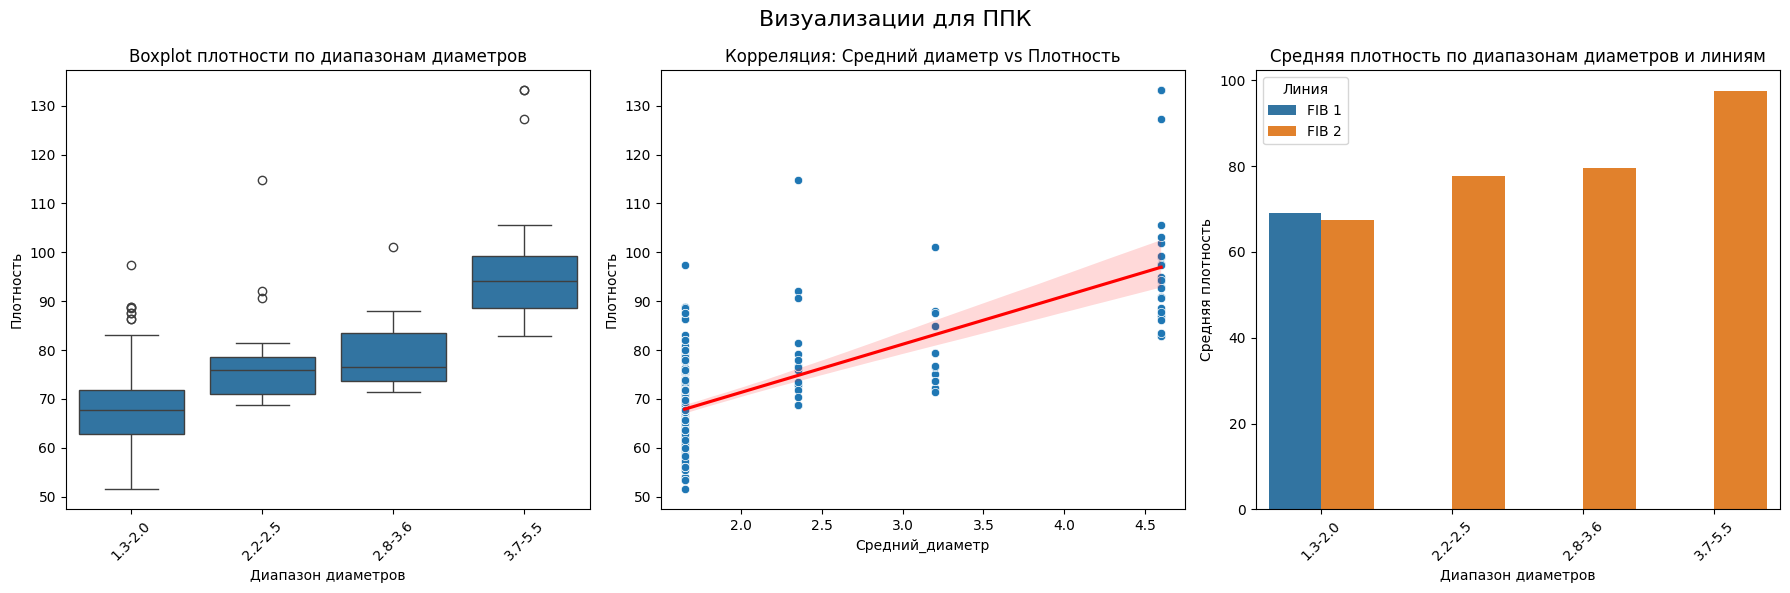


=== Визуализации для производства: СПП ===


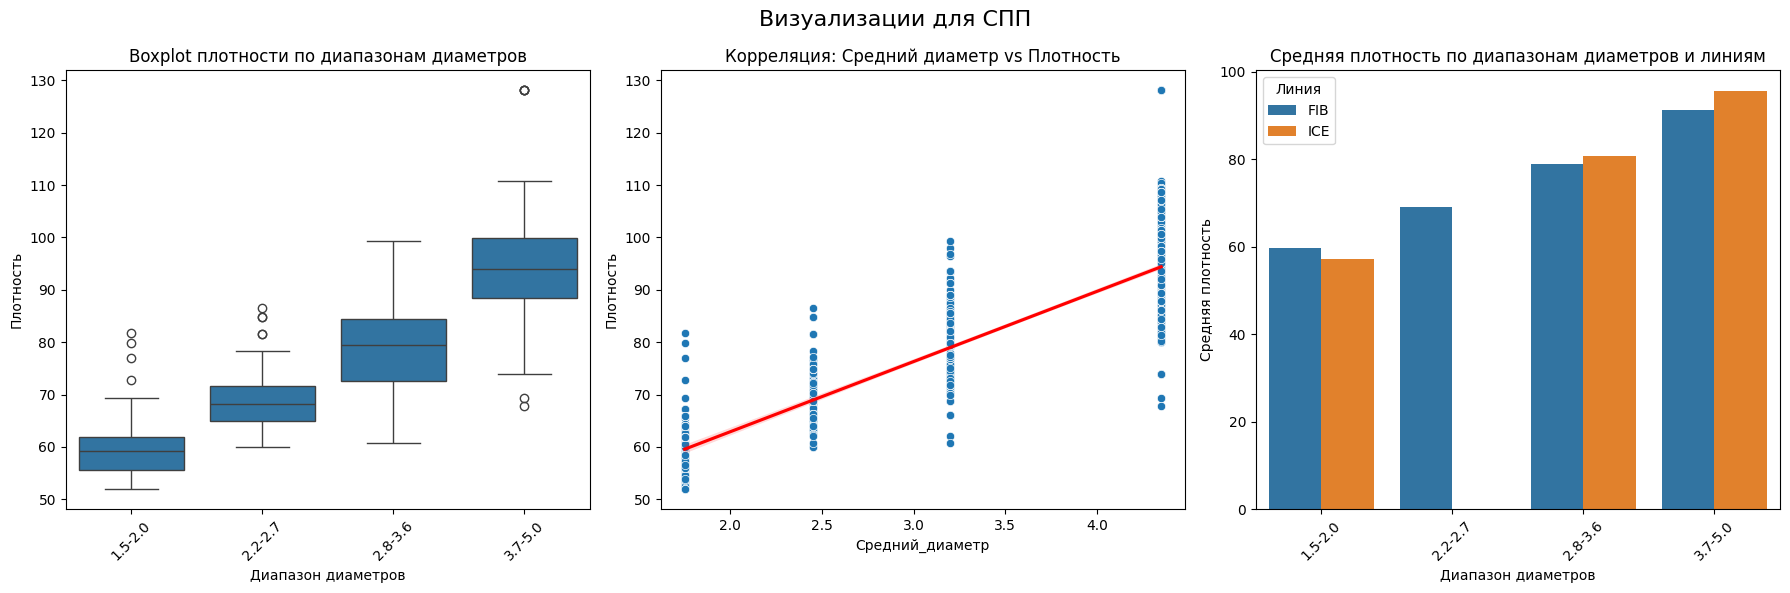


=== Сводная таблица для ППК ===
  Диапазон диаметров  Линия  Средняя_плотность  Std_плотность  LSL    USL  \
0            1.3-2.0  FIB 1          69.176471       7.671918   50   80.0   
1            1.3-2.0  FIB 2          67.396047       7.029746   50   80.0   
2            2.2-2.5  FIB 2          77.781579      11.191108   60   90.0   
3            2.8-3.6  FIB 2          79.496429       8.284333   70  100.0   
4            3.7-5.5  FIB 2          97.488000      14.146247   80  110.0   

   Количество    Cp   Cpk    Pp   Ppk  
0          68  0.65  0.47  0.65  0.47  
1         215  0.71  0.60  0.71  0.60  
2          19  0.45  0.36  0.45  0.36  
3          14  0.60  0.38  0.60  0.38  
4          25  0.35  0.29  0.35  0.29  

=== Сводная таблица для СПП ===
  Диапазон диаметров Линия  Средняя_плотность  Std_плотность  LSL    USL  \
0            1.5-2.0   FIB          59.615888       5.361509   50   80.0   
1            1.5-2.0   ICE          57.237500       3.900648   50   80.0   
2  

In [ ]:
# Основной поток
if __name__ == "__main__":
    combined, combined2, combined3 = load_and_combine_data()
    combine = process_combined_data(combined, combined2, combined3)
    pivot_result = analyze_compliance(combine)
    results = statistical_analysis_by_production(combine)
    visualize_analysis_by_production(combine)
    # Пример использования:
    # Предполагаем, что ваш DataFrame называется combine
    capability_results = calculate_capability_indices(combine)

    # Вывод сводных таблиц
    for prod, df_cap in capability_results.items():
        print(f"\n=== Сводная таблица для {prod} ===")
        print(df_cap)
        # Можно сохранить в CSV: df_cap.to_csv(f'capability_{prod}.csv', index=False)


